### localized Sidebands [2600, 3200] U [3800, 4400]

In [1]:
from DynGenModels.configs.lhco_configs import LHCOlympics_HighLevel_MLP_CondFlowMatch as Configs
from DynGenModels.datamodules.lhco.datasets import LHCOlympicsHighLevelDataset
from DynGenModels.datamodules.lhco.dataloader import LHCOlympicsDataLoader 
from DynGenModels.models.deep_nets import MLP
from DynGenModels.trainer.trainer import DynGenModelTrainer
from DynGenModels.dynamics.cnf.condflowmatch import SchrodingerBridgeFlowMatching

model_fwd = '../../results/LHCOlympicsHighLevel.SchrodingerBridgeFlowMatching.MLP_forward.2023.12.08_20h51'
configs_fwd = Configs().load(model_fwd + '/config.json')
configs_fwd.DEVICE = 'cuda:2' 
configs_fwd.workdir = model_fwd 
lhco_fwd = LHCOlympicsHighLevelDataset(configs_fwd)
cfm_fwd  = DynGenModelTrainer(dynamics = SchrodingerBridgeFlowMatching(configs_fwd),
                                model = MLP(configs_fwd), 
                                dataloader = LHCOlympicsDataLoader(lhco_fwd, configs_fwd), 
                                configs = configs_fwd)
cfm_fwd.load(model='best')

2023-12-11 17:43:03.177918: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-11 17:43:03.822563: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


+-----------------------------+--------------------------------------------------------------------------+
| Parameters                  | Values                                                                   |
+-----------------------------+--------------------------------------------------------------------------+
| DATA                        | LHCOlympicsHighLevel                                                     |
| dataset                     | ../../data/LHCOlympics2020/events_anomalydetection_high_level_cathode.h5 |
| features                    | ['mjj', 'mj1', 'delta_m', 'tau21_1', 'tau21_2']                          |
| dim_input                   | 5                                                                        |
| exchange_target_with_source | False                                                                    |
| preprocess                  | ['standardize']                                                          |
| cuts_sideband_low           | mjj: 

/home/df630/DynGenModels/src/DynGenModels/datamodules/lhco/datasets.py:53: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:204.)
  dijets = torch.Tensor(f['jet features'])


INFO: building dataloaders...
INFO: train/val/test split ratios: 0.85/0.15/0.0
INFO: train size: 63891, validation size: 11274, testing sizes: 0


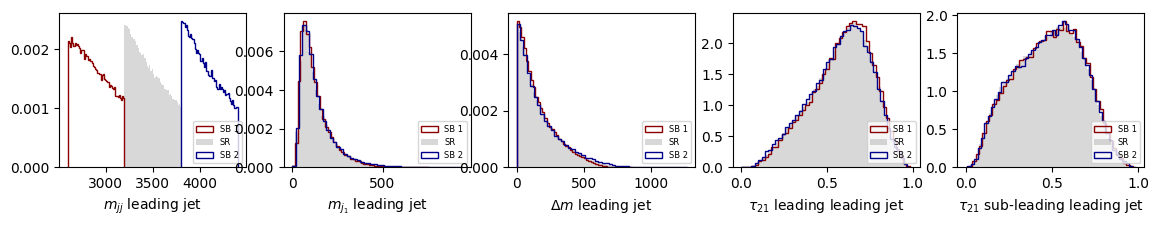

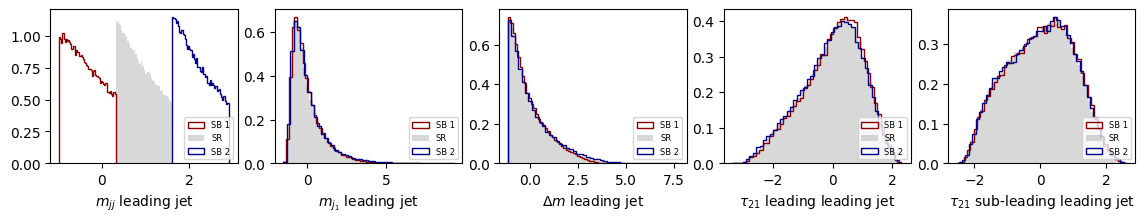

In [2]:
from utils import plot_sideband_data

plot_sideband_data(SB1=lhco_fwd.source, 
                   SR=lhco_fwd.background, 
                   SB2=lhco_fwd.target,
                   features=[r'$m_{jj}$', r'$m_{j_1}$', r'$\Delta m$', r'$\tau_{21}$ leading', r'$\tau_{21}$ sub-leading'],
                   bins=(50,50,50,50,50),
                   figsize=(14,2),
                   )

plot_sideband_data(SB1=lhco_fwd.source_preprocess, 
                   SR=lhco_fwd.background_preprocess, 
                   SB2=lhco_fwd.target_preprocess,
                   features=[r'$m_{jj}$', r'$m_{j_1}$', r'$\Delta m$', r'$\tau_{21}$ leading', r'$\tau_{21}$ sub-leading'],
                   bins=(50,50,50,50,50),
                   figsize=(14,2),
                   ) 

In [12]:
from DynGenModels.pipelines.SamplingPipeline import FlowMatchPipeline 
from DynGenModels.datamodules.lhco.dataprocess import PreProcessLHCOlympicsHighLevelData, PostProcessLHCOlympicsHighLevelData

pipeline_fwd = FlowMatchPipeline(trained_model=cfm_fwd, 
                                 configs=configs_fwd, 
                                 preprocessor=PreProcessLHCOlympicsHighLevelData,
                                 postprocessor=PostProcessLHCOlympicsHighLevelData,
                                 best_epoch_model=True)

pipeline_fwd.generate_samples(input_source=lhco_fwd.source_test)

INFO: neural ODE solver with midpoint method and steps=1000


  0%|          | 0/167 [00:00<?, ?it/s]

/home/df630/.conda/envs/flow_match_env/lib/python3.9/site-packages/torchdyn/numerics/odeint.py:84: UserWarning: Setting tolerances has no effect on fixed-step methods
  warn("Setting tolerances has no effect on fixed-step methods")


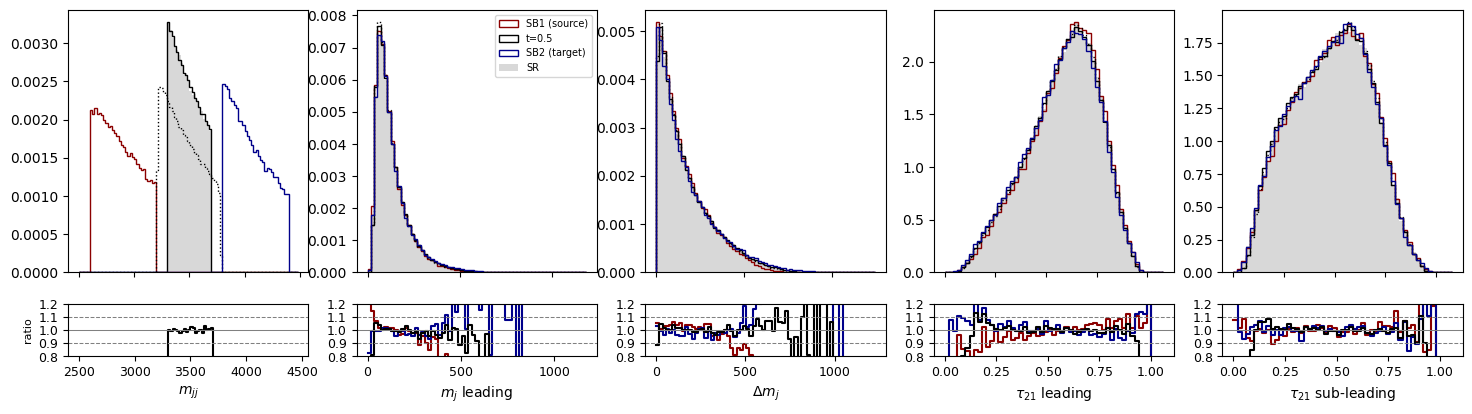

In [13]:
from utils import plot_interpolation

MJJ_BUFFER = 100
SB1_MIN = configs_fwd.cuts_sideband_low['mjj'][0]
SB2_MAX = configs_fwd.cuts_sideband_high['mjj'][1]
SR_MIN = configs_fwd.cuts_sideband_low['mjj'][1]
SR_MAX = configs_fwd.cuts_sideband_high['mjj'][0]


plot_interpolation(lhco_fwd, 
                   pipeline_fwd, 
                   preprocess=False,
                   figsize=(18, 4.5),
                   mass_window=[SR_MIN+MJJ_BUFFER, SR_MAX-MJJ_BUFFER], 
                   bins=[(SB1_MIN-MJJ_BUFFER, SB2_MAX+MJJ_BUFFER, 20),  (0, 1200, 18), (0, 1250, 18), (0, 1.1, 0.02), (0, 1.1, 0.02)], 
                   log=False, 
                   density=True)

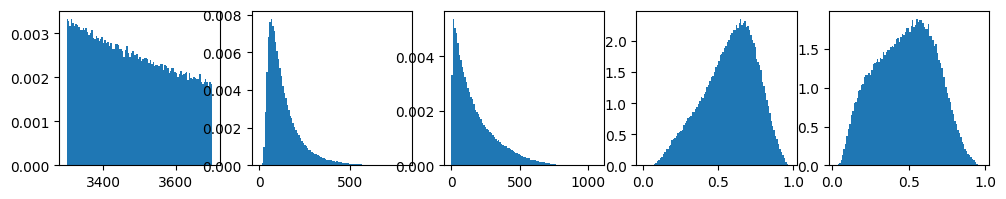

In [15]:
import numpy as np
import torch
import matplotlib.pyplot as plt

def sample_interpolation(lhco, pipeline, preprocess=False, mass_window=[3300,3700]):  

    background = lhco.background_preprocess if preprocess else lhco.background
   
    x = torch.mean(pipeline.trajectories[...,0], dim=-1) - background[...,0].mean()
    idx = torch.argmin(torch.abs(x))
    interpolation = pipeline.trajectories[idx]  
    mask = (interpolation[...,0] > mass_window[0]) & (interpolation[...,0] < mass_window[1])
    return interpolation[mask]

interpolation = sample_interpolation(lhco_fwd, pipeline_fwd, preprocess=False, mass_window=[3300, 3700])

fig, ax = plt.subplots(1, 5, figsize=(12, 2))
ax[0].hist(interpolation[:,0], bins=100, density=True)
ax[1].hist(interpolation[:,1], bins=100, density=True)
ax[2].hist(interpolation[:,2], bins=100, density=True)
ax[3].hist(interpolation[:,3], bins=100, density=True)
ax[4].hist(interpolation[:,4], bins=100, density=True)
plt.show()

In [16]:
interpolation.shape

torch.Size([228140, 5])

In [17]:
np.save(model_fwd + '/background_interpolation.npy', interpolation[..., 1:])

### Full Sidebands [1500, 3200] U [3800, 5500]

In [18]:
from DynGenModels.configs.lhco_configs import LHCOlympics_HighLevel_MLP_CondFlowMatch as Configs
from DynGenModels.datamodules.lhco.datasets import LHCOlympicsHighLevelDataset
from DynGenModels.datamodules.lhco.dataloader import LHCOlympicsDataLoader 
from DynGenModels.models.deep_nets import MLP
from DynGenModels.trainer.trainer import DynGenModelTrainer
from DynGenModels.dynamics.cnf.condflowmatch import SchrodingerBridgeFlowMatching

model_fwd = '../../results/LHCOlympicsHighLevel.SchrodingerBridgeFlowMatching.MLP_forward.2023.12.11_09h13'
configs_fwd = Configs().load(model_fwd + '/config.json')
configs_fwd.DEVICE = 'cuda:1' 
configs_fwd.workdir = model_fwd 
lhco_fwd = LHCOlympicsHighLevelDataset(configs_fwd)
cfm_fwd  = DynGenModelTrainer(dynamics = SchrodingerBridgeFlowMatching(configs_fwd),
                                model = MLP(configs_fwd), 
                                dataloader = LHCOlympicsDataLoader(lhco_fwd, configs_fwd), 
                                configs = configs_fwd)
cfm_fwd.load(model='best')

+-----------------------------+--------------------------------------------------------------------------+
| Parameters                  | Values                                                                   |
+-----------------------------+--------------------------------------------------------------------------+
| DATA                        | LHCOlympicsHighLevel                                                     |
| dataset                     | ../../data/LHCOlympics2020/events_anomalydetection_high_level_cathode.h5 |
| features                    | ['mjj', 'mj1', 'delta_m', 'tau21_1', 'tau21_2']                          |
| dim_input                   | 5                                                                        |
| exchange_target_with_source | False                                                                    |
| preprocess                  | ['normalize']                                                            |
| cuts_sideband_low           | mjj: 

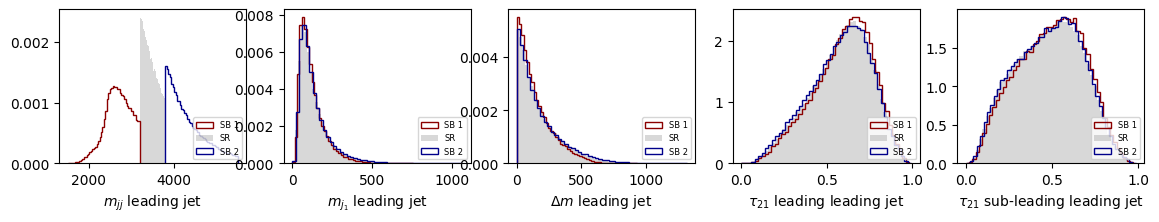

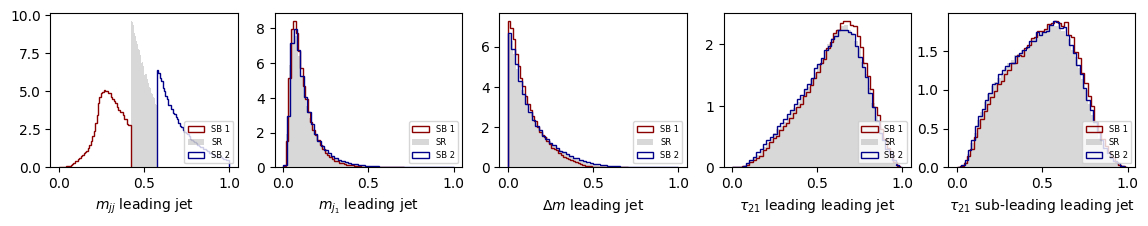

In [19]:
from utils import plot_sideband_data

plot_sideband_data(SB1=lhco_fwd.source, 
                   SR=lhco_fwd.background, 
                   SB2=lhco_fwd.target,
                   features=[r'$m_{jj}$', r'$m_{j_1}$', r'$\Delta m$', r'$\tau_{21}$ leading', r'$\tau_{21}$ sub-leading'],
                   bins=(50,50,50,50,50),
                   figsize=(14,2),
                   )

plot_sideband_data(SB1=lhco_fwd.source_preprocess, 
                   SR=lhco_fwd.background_preprocess, 
                   SB2=lhco_fwd.target_preprocess,
                   features=[r'$m_{jj}$', r'$m_{j_1}$', r'$\Delta m$', r'$\tau_{21}$ leading', r'$\tau_{21}$ sub-leading'],
                   bins=(50,50,50,50,50),
                   figsize=(14,2),
                   ) 

In [27]:
from DynGenModels.pipelines.SamplingPipeline import FlowMatchPipeline 
from DynGenModels.datamodules.lhco.dataprocess import PreProcessLHCOlympicsHighLevelData, PostProcessLHCOlympicsHighLevelData

pipeline_fwd = FlowMatchPipeline(trained_model=cfm_fwd, 
                                 configs=configs_fwd, 
                                #  preprocessor=PreProcessLHCOlympicsHighLevelData,
                                #  postprocessor=PostProcessLHCOlympicsHighLevelData,
                                 best_epoch_model=True)

pipeline_fwd.generate_samples(input_source=lhco_fwd.source_test_preprocess)

INFO: neural ODE solver with midpoint method and steps=1000


  0%|          | 0/282 [00:00<?, ?it/s]

/home/df630/.conda/envs/flow_match_env/lib/python3.9/site-packages/torchdyn/numerics/odeint.py:84: UserWarning: Setting tolerances has no effect on fixed-step methods
  warn("Setting tolerances has no effect on fixed-step methods")


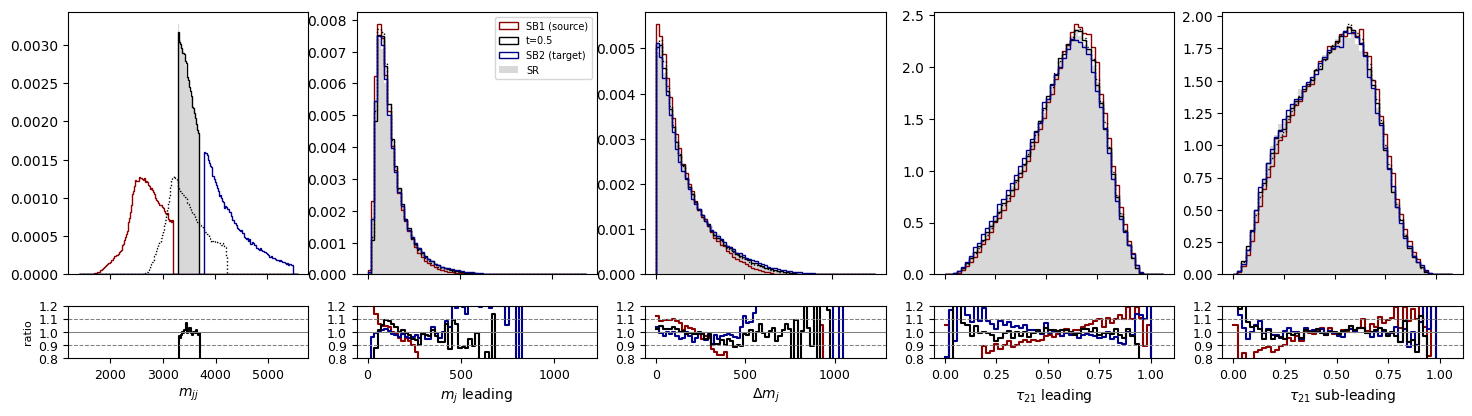

In [21]:
from utils import plot_interpolation

MJJ_BUFFER = 100
SB1_MIN = configs_fwd.cuts_sideband_low['mjj'][0]
SB2_MAX = configs_fwd.cuts_sideband_high['mjj'][1]
SR_MIN = configs_fwd.cuts_sideband_low['mjj'][1]
SR_MAX = configs_fwd.cuts_sideband_high['mjj'][0]


plot_interpolation(lhco_fwd, 
                   pipeline_fwd, 
                   preprocess=False,
                   figsize=(18, 4.5),
                   mass_window=[SR_MIN+MJJ_BUFFER, SR_MAX-MJJ_BUFFER], 
                   bins=[(SB1_MIN-MJJ_BUFFER, SB2_MAX+MJJ_BUFFER, 20),  (0, 1200, 18), (0, 1250, 18), (0, 1.1, 0.02), (0, 1.1, 0.02)], 
                   log=False, 
                   density=True)

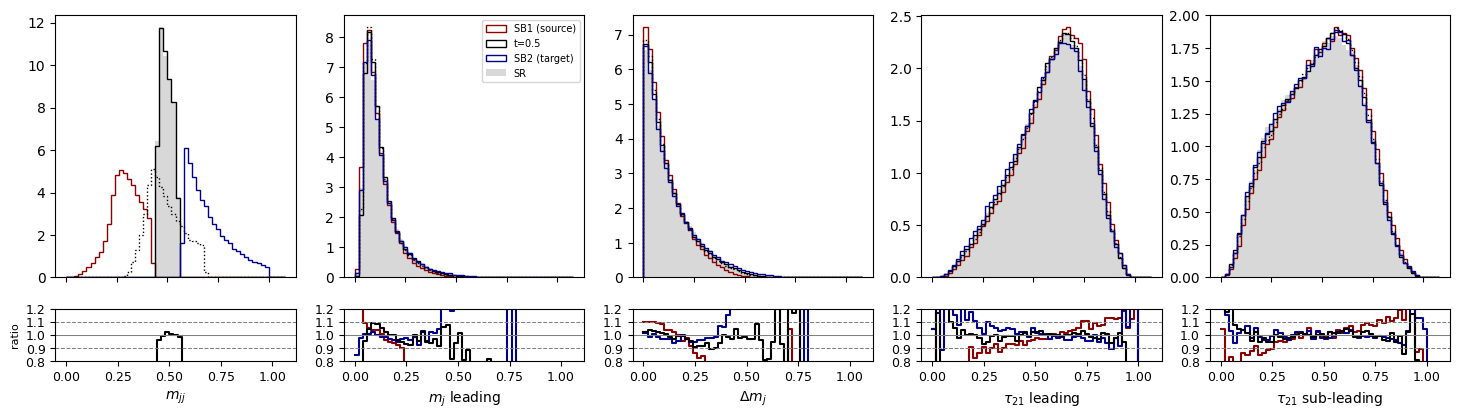

In [28]:
from utils import plot_interpolation

plot_interpolation(lhco_fwd, 
                   pipeline_fwd, 
                   preprocess=True,
                   figsize=(18, 4.5),
                   mass_window=[0.45, 0.55], 
                   bins=[(0, 1.1, 0.02), (0, 1.1, 0.02), (0, 1.1, 0.02), (0, 1.1, 0.02), (0, 1.1, 0.02)], 
                   log=False, 
                   density=True)

t= tensor(0.4760)


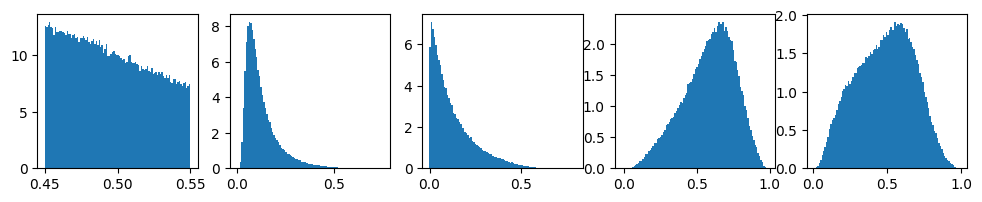

torch.Size([208069, 5])

In [30]:
import numpy as np
import torch
import matplotlib.pyplot as plt

def sample_interpolation(lhco, pipeline, preprocess=False, mass_window=[3300,3700]):  

    background = lhco.background_preprocess if preprocess else lhco.background
   
    x = torch.mean(pipeline.trajectories[...,0], dim=-1) - background[...,0].mean()
    idx = torch.argmin(torch.abs(x))
    interpolation = pipeline.trajectories[idx]  
    mask = (interpolation[...,0] > mass_window[0]) & (interpolation[...,0] < mass_window[1])
    print('t=',idx/len(pipeline.trajectories))
    return interpolation[mask]

interpolation = sample_interpolation(lhco_fwd, pipeline_fwd, preprocess=True, mass_window=[0.45, 0.55])

fig, ax = plt.subplots(1, 5, figsize=(12, 2))
ax[0].hist(interpolation[:,0], bins=100, density=True)
ax[1].hist(interpolation[:,1], bins=100, density=True)
ax[2].hist(interpolation[:,2], bins=100, density=True)
ax[3].hist(interpolation[:,3], bins=100, density=True)
ax[4].hist(interpolation[:,4], bins=100, density=True)
plt.show()


interpolation.shape

In [31]:
np.save(model_fwd + '/background_interpolation.npy', interpolation[..., 1:])